<a href="https://colab.research.google.com/github/pradeep058888/Project2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install extra libraries if not present
!pip install seaborn xgboost

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from your path
file_path = "/content/drive/MyDrive/Project2/sensor.csv"
df = pd.read_csv(file_path)

# Check the first few rows
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    time   SensorA   SensorB   SensorC
0  00:00  1.416250  4.219930  3.139646
1  00:01  3.534439       NaN  3.064088
2  00:02  5.659733       NaN  2.925565
3  00:03  5.640167  3.073650  5.381210
4  00:04  4.454474  1.554044  1.055965


In [ ]:
# Convert 'time' column to datetime index (assuming it is HH:MM format for one day)
df['time'] = pd.to_datetime(df['time'], format='%H:%M')
df.set_index('time', inplace=True)

# Handle missing values by forward fill
df = df.ffill()

# Basic info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 1900-01-01 00:00:00 to 1900-01-01 23:59:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SensorA  1440 non-null   float64
 1   SensorB  1440 non-null   float64
 2   SensorC  1440 non-null   float64
dtypes: float64(3)
memory usage: 45.0 KB
None


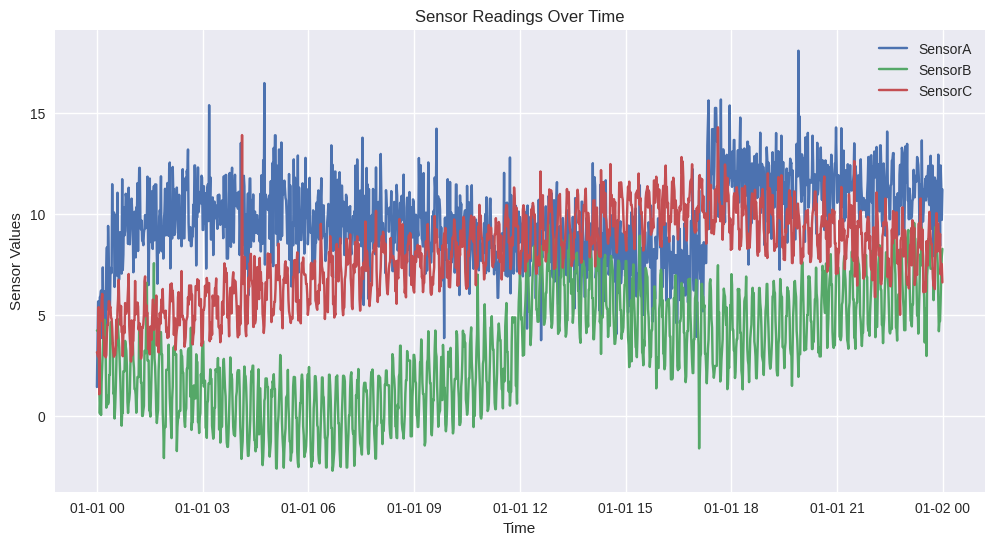

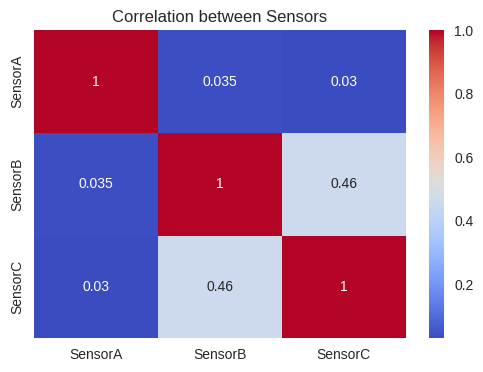

In [ ]:
# Set plot style safely
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')

# Plot all sensors
plt.figure(figsize=(12,6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.legend()
plt.title("Sensor Readings Over Time")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Sensors")
plt.show()


In [ ]:
# Use 80% data for training, 20% for testing
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1152, 3)
Test shape: (288, 3)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

def auto_arima(train, test, p_values=range(0,3), d_values=range(0,2), q_values=range(0,3)):
    best_score, best_cfg = float("inf"), None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p,d,q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(test))
                    rmse = sqrt(mean_squared_error(test, forecast))
                    if rmse < best_score:
                        best_score, best_cfg, best_model = rmse, (p,d,q), model_fit
                except:
                    continue
    return best_model, best_cfg, best_score

# Run Auto-ARIMA
arima_model, arima_cfg, arima_rmse = auto_arima(train['SensorA'], test['SensorA'])
print("Best ARIMA Order:", arima_cfg)
print("ARIMA RMSE:", arima_rmse)


Best ARIMA Order: (2, 1, 1)
ARIMA RMSE: 1.421198474970533


In [ ]:
def auto_sarima(train, test,
                p_values=range(0,3), d_values=range(0,2), q_values=range(0,3),
                P_values=range(0,2), D_values=range(0,2), Q_values=range(0,2), s_values=[30,60]):
    best_score, best_cfg = float("inf"), None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                try:
                                    model = SARIMAX(train,
                                                    order=(p,d,q),
                                                    seasonal_order=(P,D,Q,s))
                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.forecast(steps=len(test))
                                    rmse = sqrt(mean_squared_error(test, forecast))
                                    if rmse < best_score:
                                        best_score, best_cfg, best_model = rmse, (p,d,q,P,D,Q,s), model_fit
                                except:
                                    continue
    return best_model, best_cfg, best_score

# Run Auto-SARIMA
sarima_model, sarima_cfg, sarima_rmse = auto_sarima(train['SensorA'], test['SensorA'])
print("Best SARIMA Order:", sarima_cfg)
print("SARIMA RMSE:", sarima_rmse)


Best SARIMA Order: (2, 0, 1, 1, 0, 0, 60)
SARIMA RMSE: 1.4043170204445823


In [ ]:
# Create features from lags
def create_lag_features(data, lags=3):
    df_new = pd.DataFrame(data)
    for i in range(1, lags+1):
        df_new[f'lag_{i}'] = df_new['SensorA'].shift(i)
    return df_new.dropna()

lagged = create_lag_features(df[['SensorA']], lags=3)

# Train-test split for ML
train_ml = lagged.iloc[:train_size]
test_ml = lagged.iloc[train_size:]

X_train, y_train = train_ml.drop('SensorA', axis=1), train_ml['SensorA']
X_test, y_test = test_ml.drop('SensorA', axis=1), test_ml['SensorA']

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# Evaluate
rmse_rf = sqrt(mean_squared_error(y_test, rf_preds))
print("Random Forest RMSE:", rmse_rf)


Random Forest RMSE: 1.7357228366517878


In [ ]:
print("Model Comparison (RMSE):")
print("ARIMA :", rmse_arima)
print("SARIMA:", sarima_rmse)
print("Random Forest:", rmse_rf)


Model Comparison (RMSE):
ARIMA : 1.42171056852215
SARIMA: 1.4043170204445823
Random Forest: 1.7357228366517878


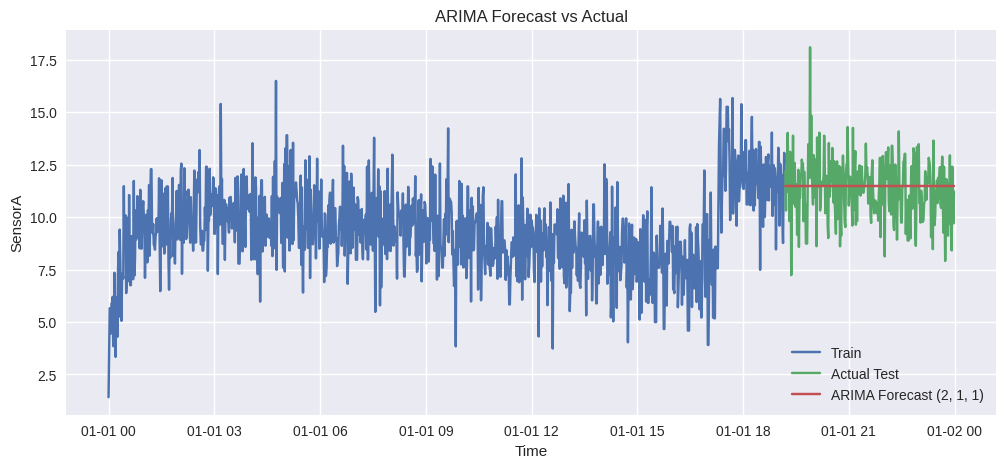

In [ ]:
# Forecast using best ARIMA model
arima_forecast = arima_model.forecast(steps=len(test))

plt.figure(figsize=(12,5))
plt.plot(train.index, train['SensorA'], label='Train')
plt.plot(test.index, test['SensorA'], label='Actual Test')
plt.plot(test.index, arima_forecast, label=f'ARIMA Forecast {arima_cfg}')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("SensorA")
plt.legend()
plt.show()


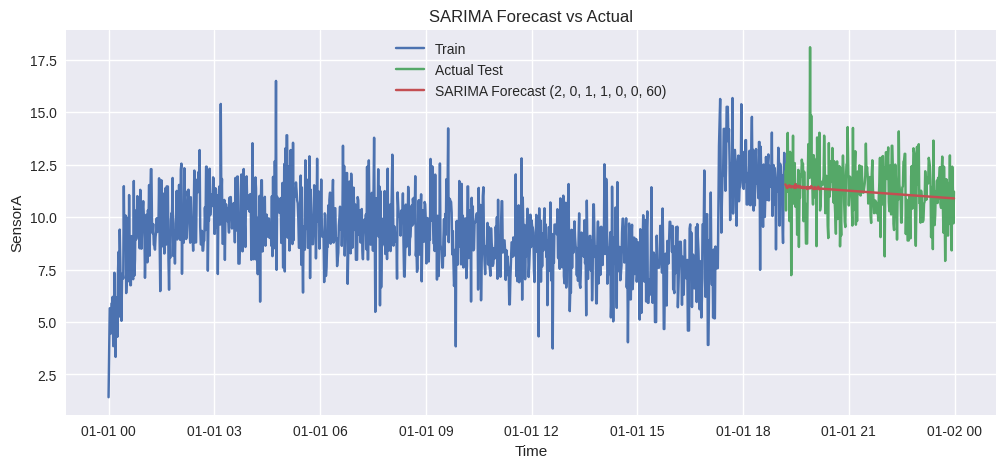

In [ ]:
# Forecast using best SARIMA model
sarima_forecast = sarima_model.forecast(steps=len(test))

plt.figure(figsize=(12,5))
plt.plot(train.index, train['SensorA'], label='Train')
plt.plot(test.index, test['SensorA'], label='Actual Test')
plt.plot(test.index, sarima_forecast, label=f'SARIMA Forecast {sarima_cfg}')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("SensorA")
plt.legend()
plt.show()


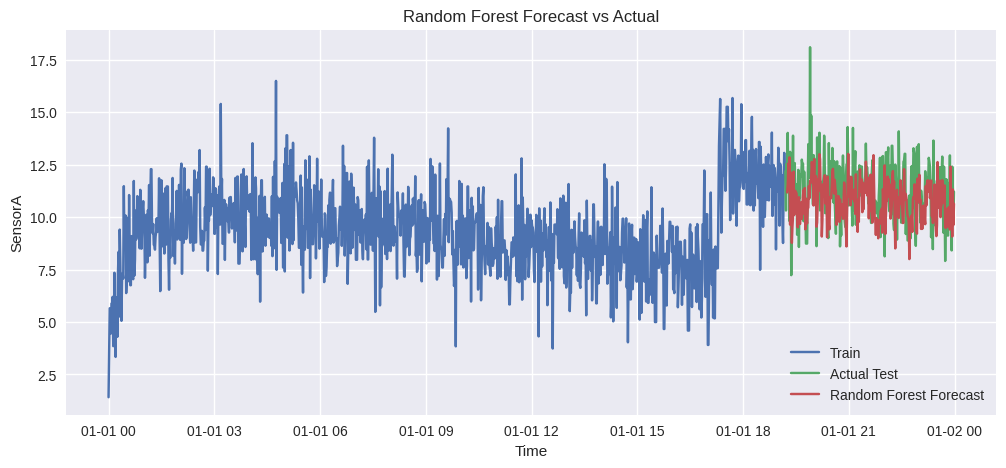

In [ ]:
# Align RF predictions with test index
rf_forecast = pd.Series(rf_preds, index=y_test.index)

plt.figure(figsize=(12,5))
plt.plot(train.index, train['SensorA'], label='Train')
plt.plot(test.index, test['SensorA'], label='Actual Test')
plt.plot(rf_forecast.index, rf_forecast, label='Random Forest Forecast')
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("SensorA")
plt.legend()
plt.show()


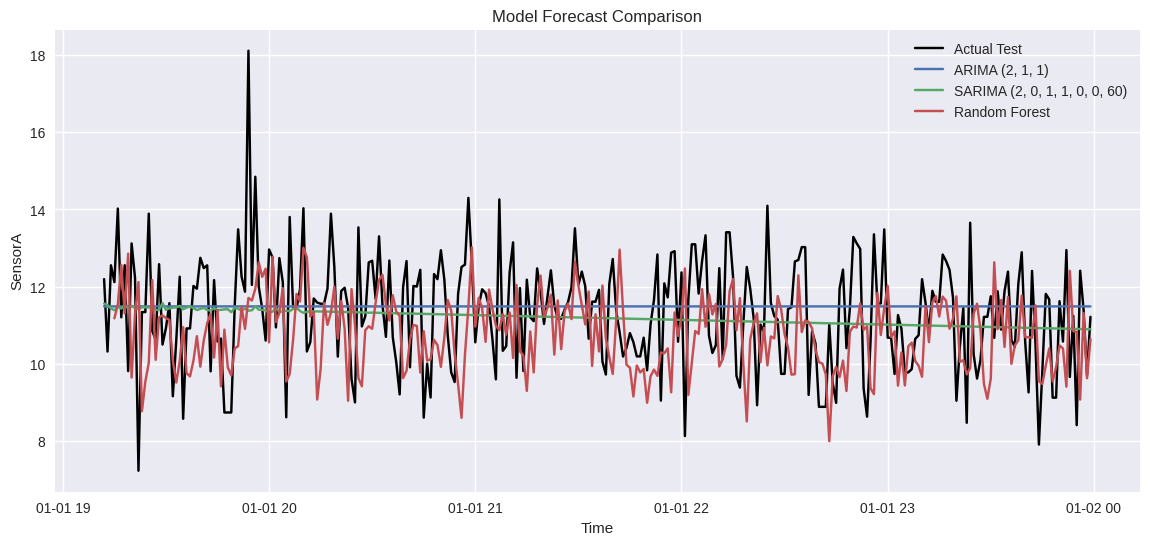

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test.index, test['SensorA'], label='Actual Test', color='black')
plt.plot(test.index, arima_forecast, label=f'ARIMA {arima_cfg}')
plt.plot(test.index, sarima_forecast, label=f'SARIMA {sarima_cfg}')
plt.plot(rf_forecast.index, rf_forecast, label='Random Forest')
plt.title("Model Forecast Comparison")
plt.xlabel("Time")
plt.ylabel("SensorA")
plt.legend()
plt.show()
